# Part A

#### Research Question:
Are age, gender and education (edication_num) correlated with hours per week?

In [81]:
# Deprocations of jupyter warnings about sns functions that will be deprocated in the future. (sns.distplot)
import warnings
warnings.filterwarnings('ignore')

#Reading a CSV file into pandas Dataframe
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import random
from scipy.stats import f,norm,t

import pprint
import sys

random.seed(1)
# Removing missing values
missing_values = ["n/a", "na", "--","?"]
df_full = pd.read_csv("adult.csv",sep=",", na_values = missing_values)
df_full=df_full.dropna()

# Converting string columns to binary.
df_full['gender'] =df_full['gender'].map({'Female': 0, 'Male': 1})
df_full['income'] = df_full['income'].map({'>50K': 1, '<=50K': 0})

# Reducing dataset size to 200 samples and removing unused columns.
df_full['aux_columns_of_ones']= [1]*df_full.shape[0]
df_full = df_full[['aux_columns_of_ones','gender','age','educational-num','hours-per-week']]
df_200_samples=df_full.sample(n = 200)
df_200_samples.head()

,aux_columns_of_ones,gender,age,educational-num,hours-per-week
26787,1,1,47,9,60
45647,1,0,22,12,25
23116,1,0,39,14,40
32479,1,1,70,9,40
16316,1,1,48,7,40


### Secition 1
#### a

In [82]:
def create_targets_and_lables(df_data):
    X=df_data.iloc[:, 0:df_data.shape[1]-1].values
    Y=df_data.iloc[:, df_data.shape[1]-1:].values
    return X,Y

def estimate_beta(df_data):
    X,Y =create_targets_and_lables(df_data)
    beta_est=((np.linalg.pinv(X.T@X))@X.T)@Y
    return beta_est
  

X_sampled,Y_sampled=create_targets_and_lables(df_200_samples)
beta_est_200=estimate_beta(df_200_samples)

Y_pred = X_sampled@beta_est_200

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(Y_pred, axis=1))

var_est = np.linalg.inv(X_sampled.T @ V @ X_sampled)

CI_on_cov_matrix={}
z_quantile=norm.ppf(1-0.05/2)
for i,beta in enumerate(beta_est_200):
    CI_on_cov_matrix["beta_{}".format(i)]=[beta[0]-z_quantile*math.sqrt(var_est[i][i]),beta[0]+z_quantile*math.sqrt(var_est[i][i])]
    
print('CI per beta')
pprint.pprint(CI_on_cov_matrix)    

CI per beta
{'beta_0': [29.84978834202346, 30.067421986730622],
 'beta_1': [2.533628201390936, 2.624463156125353],
 'beta_2': [0.09856321560764526, 0.1019528953875481],
 'beta_3': [0.6685922676214852, 0.6847494118483374]}


##### b

In Linear Regression MLE for variance is MS Residuals

In [83]:
# esimates standart error of Linear Regression error(epsilon) using bootstrap
def estimate_se_via_bootstrap(df,B,n=150):
    sampled_se_list=[]
    for i in range(B):
        df=df.sample(n, replace=True)
        X,Y=create_targets_and_lables(df)
        n_p=X.shape[0]-X.shape[1]
        beta_est=estimate_beta(df)
        Y_est=X@beta_est
        var_est=np.sum(np.square(Y-Y_est))/n_p
        sampled_se_list.append(np.sqrt(var_est))
    return np.sqrt(np.mean(sampled_se_list))


se_est = estimate_se_via_bootstrap(df_200_samples,B=400)


CI_bootstrap={}
z_quantile=norm.ppf(1-0.05/2)

for i,beta in enumerate(beta_est_200):
    CI_bootstrap["beta_{}".format(i)]=[beta[0]-z_quantile*se_est,beta[0]+z_quantile*se_est]
    
print('CI per beta')
pprint.pprint(CI_bootstrap)  

CI per beta
{'beta_0': [28.76286685992696, 31.154343468827122],
 'beta_1': [1.3833073743080617, 3.7747839832082275],
 'beta_2': [-1.0954802489524862, 1.2959963599476796],
 'beta_3': [-0.5190674647151716, 1.8724091441849942]}


#### c
Pivotal CI from lecture when the distribution is unknown: $[2\hat{\theta_{n}}-\hat{\theta^*_{1-\alpha/2}},2\hat{\theta_{n}}+\hat{\theta^*_{\alpha/2}}]$

In [84]:
# estimation of CI of weights (betas) in Linear Regression using bootstrap and Pivot method for estimation.
def estimate_betas_via_pivot_method(df,B):
    sampled_betas=[]
    X,Y=create_targets_and_lables(df)
    beta_est=estimate_beta(df)
    n=200
#     sample betas using bootstrap 
    for i in range(B):
        df=df.sample(n, replace=True)
        X,Y=create_targets_and_lables(df)
        beta=estimate_beta(df)
        beta = [item for sublist in beta for item in sublist]
        sampled_betas.append(beta)
        
    CI={}
#     generate CI using pivot method
    for i in range(len(beta_est)):
#         samples of beta_i corresponding to beta_i that estimated from original df of 200 samples
        sampled_beta_i=[betas[i] for betas in sampled_betas]
        sampled_beta_i.sort()
        alpha=0.05
        upper_percentile=int((alpha/2)*B)
        lower_percentile=int((1-alpha/2)*B)
        ci=[2*beta_est[i][0]-sampled_beta_i[lower_percentile],2*beta_est[i][0]+sampled_beta_i[upper_percentile]]
        CI["beta_{}".format(i)]=ci


    print('CI per beta')
    pprint.pprint(CI)
    return CI

CI_pivot=estimate_betas_via_pivot_method(df_200_samples,B=400)




CI per beta
{'beta_0': [25.63975333957478, 60.12707618768959],
 'beta_1': [-8.688062488644587, 0.08797140766806422],
 'beta_2': [-1.0465630755041868, -0.5687146582359874],
 'beta_3': [-1.8334715073441372, -0.06855360395734555]}


### Secition 2

In [85]:
# estimation of CI of weights (betas) in Linear Regression using bootstrap and Pivot method for estimation.
def estimate_betas_via_quantiles_method(df,B):
    sampled_betas=[]
    X,Y=create_targets_and_lables(df)
    beta_est=estimate_beta(df)
    n=200
    for i in range(B):
        df=df.sample(n, replace=True)
        X,Y=create_targets_and_lables(df)
        beta=estimate_beta(df)
        sampled_betas.append(beta) 
        
    alpha=0.05
    CI={}
    for i in range(len(beta_est)):
        sampled_beta_i=[betas[i][0] for betas in sampled_betas]
        sampled_beta_i.sort()
        quantile_lower=sampled_beta_i[int((alpha/2)*n)]
        quantile_upper=sampled_beta_i[int((1-alpha/2)*n)]
        CI["beta_{}".format(i)]=[quantile_lower,quantile_upper]
    
    print('CI per beta')
    pprint.pprint(CI)
    return CI

CI_quantiles=estimate_betas_via_quantiles_method(df_200_samples,B=400)

CI per beta
{'beta_0': [-0.822489357999423, 2.918675122120325],
 'beta_1': [0.8779759799691584, 6.740925559126089],
 'beta_2': [-1.888888888930306, -0.29727971028843986],
 'beta_3': [-4.444444444641773, 3.4419401792821778]}


In [10]:
len_ci_cov_matrix=[ci[1]-ci[0] for beta,ci in CI_on_cov_matrix.items()]
len_ci_bootstrap=[ci[1]-ci[0] for beta,ci in CI_bootstrap.items()]
len_ci_pivot=[ci[1]-ci[0] for beta,ci in CI_pivot.items()]
len_ci_quantiles=[ci[1]-ci[0] for beta,ci in CI_quantiles.items()]
methods = [len_ci_cov_matrix,len_ci_bootstrap,len_ci_pivot,len_ci_quantiles]
methods_name = ['Using covariance matrix is :', 'bootstrap to estimate s.e is :', 'Using pivot method is :', 'Using quantiles method is :']


for index, method in enumerate(methods):
    print('{}'.format(methods_name[index]))
    for i in range(len(len_ci_cov_matrix)):
        print('beta_{} ci length = {}'.format(i, method[i]))
    print('-'*50)
        
        
beta_est_full_df=estimate_beta(df_full)

def check_beta_in_ci(CI):
    for i in range(len(beta_est_full_df)):
        if CI["beta_{}".format(i)][0] <=beta_est_full_df[i]<=CI["beta_{}".format(i)][1]:
            print ("beta_{} = {} is in CI ={}".format(i,beta_est_full_df[i],CI["beta_{}".format(i)]))
        else:
            print ("beta_{} = {} not in CI ={}".format(i,beta_est_full_df[i],CI["beta_{}".format(i)]))
print()
print()
print("Now we'll check if beta is in the ci:")
print()
print('For CI calc. with cov. matrix:')
print('-'*80)
check_beta_in_ci(CI_on_cov_matrix)
print('-'*80)
print('For CI calc. with bootstrap:')
print('-'*80)
check_beta_in_ci(CI_bootstrap)
print('-'*80)
print('For CI calc. with pivot method:')
print('-'*80)
check_beta_in_ci(CI_pivot)
print('-'*80)
print('For CI calc. with quantiles method:')
print('-'*80)
check_beta_in_ci(CI_quantiles)
print('-'*80)

Using covariance matrix is :
beta_0 ci length = 0.23139253720485442
beta_1 ci length = 0.10162196014054814
beta_2 ci length = 0.0031715199267053212
beta_3 ci length = 0.016556218655839672
--------------------------------------------------
bootstrap to estimate s.e is :
beta_0 ci length = 3.635632702135588
beta_1 ci length = 3.6356327021355908
beta_2 ci length = 3.635632702135591
beta_3 ci length = 3.6356327021355916
--------------------------------------------------
Using pivot method is :
beta_0 ci length = -163.1814317999552
beta_1 ci length = 93.12089880564693
beta_2 ci length = 2.3474097044905804
beta_3 ci length = 20.079989055084177
--------------------------------------------------
Using quantiles method is :
beta_0 ci length = 32.185628259976
beta_1 ci length = 11.860790698205022
beta_2 ci length = 0.3184796278049318
beta_3 ci length = 0.37030229312539653
--------------------------------------------------


Now we'll check if beta is in the ci:

For CI calc. with cov. matrix:
--

### Secition 3
#### a.

In [108]:
# Substruct from full data the 200 samples from previous sections.
df_without_sub_sample=df_full.drop(df_200_samples.index)
df_100_samples=df_without_sub_sample.sample(n = 100)
X_new,Y_new=create_targets_and_lables(df_100_samples)

Y_pred_100=X_new@beta_est_200
print('The predicted labels are: {}'.format(Y_pred_100.T[0]))

The predicted labels are: [41.36231966 43.54033312 44.74342979 41.13413979 38.63021662 38.93099078
 41.13413979 36.6002041  42.13672034 40.63537773 44.01648785 45.0190684
 45.04391981 42.31210091 42.33723645 38.93099078 40.83589384 41.03388173
 41.03388173 42.2369784  45.44523617 42.21184285 46.24701648 44.24185537
 40.4826045  45.59519705 41.43744217 42.03646229 43.28954591 44.56776508
 45.14446201 42.13672034 41.28691302 45.54521009 47.32471954 44.54262954
 41.05930142 39.35715855 48.47754511 38.73047467 40.4323334  38.60283699
 38.05380383 42.71313313 41.136668   46.04650037 40.30946801 45.44495204
 45.04391981 40.00869384 47.29958399 42.16438411 41.30952035 41.46257772
 43.64030704 38.95612633 46.42239704 43.04128692 42.13672034 40.13408745
 41.36203552 41.03388173 39.53253912 42.83852673 43.33981701 42.13672034
 38.73047467 42.83852673 40.40972607 42.33976467 40.56025522 40.25948105
 40.2846166  40.93615189 39.17924978 47.29958399 39.65793272 42.06384191
 41.63543007 41.76306775 4

#### b+c

In [109]:
z=norm.ppf(1-0.05/2)

#Estimate s.e of epsilon using bootstrap method as in section 1.b
se_est = estimate_se_via_bootstrap(df_100_samples,B=400)
C=np.linalg.inv(X_new.T@X_new)

CI={}
num_of_y_in_CI=0

#Calculate CI for each predicted y.
for i,y_pred in enumerate(Y_pred_100): 
    se_of_expected_val=math.sqrt((se_est**2)*X_new[i].T@C@X_new[i])
    CI[i]=[y_pred[0]-z*se_of_expected_val,y_pred[0]+z*se_of_expected_val]
    if CI[i][0]<=Y_new[i][0]<=CI[i][1]:
        num_of_y_in_CI+=1
        
percent=(num_of_y_in_CI/len(Y_new))*100
print('Percent of times the true value is in CI = {}%'.format(percent))

Percent of times the true value is in CI = 6.0%


A 95% confidence interval means that if we were to take 100 different samples and compute a 95% confidence interval for each sample, then approximately 95 of the 100 confidence intervals will contain the true value.

Percent we got is very low, not even close to 95%. It means our estimations are bad.


#### d.

When we want to find PI (רווח תחזית) for $Y_{new} $ we add variance of single sample to the variance variable. Such that $ var(y_{new}|x_{new})=\sigma^2_{\epsilon}*X_{new}^T*C*X_{new}+\sigma^2_{\epsilon} $

Knowing that, we can estimate $ \sigma_{\epsilon} $ using one of the methods from section 1, and compute the PI

# Part B

### Section 1

#### Our question is:
Is value distribution of age among people who earn more(>50K) necessarily higher than the age of people who earn less (<=50K)?
X- age Y-income

### Section 2

In [13]:
# Deprocations of jupyter warnings about sns functions that will be deprocated in the future. (sns.distplot)
import warnings
warnings.filterwarnings('ignore')

#Reading a CSV file into pandas Dataframe
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import random
from scipy.stats import f
from scipy.stats import norm
import pprint
import sys

random.seed(1)
# Removing missing values
missing_values = ["n/a", "na", "--","?"]
df_full = pd.read_csv("adult.csv",sep=",", na_values = missing_values)
df_full=df_full.dropna()

# Converting string columns to binary.
df_full['gender'] =df_full['gender'].map({'Female': 0, 'Male': 1})
df_full['income'] = df_full['income'].map({'>50K': 1, '<=50K': 0})

df_200_samples=df_full.sample(n = 200)
df_200_samples.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
9221,40,Private,60594,Some-college,10,Divorced,Other-service,Unmarried,White,0,0,0,30,United-States,0
17033,58,Self-emp-not-inc,87510,10th,6,Married-civ-spouse,Craft-repair,Husband,White,1,0,0,40,United-States,0
18406,24,Private,109307,HS-grad,9,Never-married,Sales,Own-child,White,1,0,0,45,United-States,0
14217,47,Local-gov,179048,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,1,0,0,40,United-States,0
30673,34,Private,344275,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,1,0,0,70,United-States,0


### Section 3.a

$ \mu_{1}= $ expected value of age in income category (>50K) 

$ \mu_{2}= $ expected value of age in income category (<=50K) 

$ \delta=\mu_{1}-\mu_{2} $

 MLE for $\mu$ is $\bar{X} $ 

calculating MLE for $ \delta$:

 ->  MLE for  $\delta$ is  $\bar{X_1}-\bar{X_2} $


In [14]:
# MLE of the expected value of 'age' according to categories in 'income' 
EV_MLE_1=df_200_samples.groupby('income')['age'].mean()[1]
EV_MLE_2=df_200_samples.groupby('income')['age'].mean()[0]

delta_MLE=EV_MLE_1-EV_MLE_2

print("MLE of mu1 is {}, MLE of mu2 is {} ".format(EV_MLE_1,EV_MLE_2))
print("MLE of delta is {}".format(delta_MLE))

MLE of mu1 is 44.57142857142857, MLE of mu2 is 36.503311258278146 
MLE of delta is 8.068117313150424


### Section 3.b
$s_p=\sqrt{((n_1-1)*s_1^2+(n_2-1)*s_2^2)\div(n_1+n_2-2)}$

$ s.e = \sqrt{(s_p^2/n_1)+(s_p^2/n_2)}$

$ CI = [\delta \pm t*s.e] $ 

In [15]:
# SE of the expected value of 'age' according to categories in 'income'
SE_1=df_200_samples.groupby('income')['age'].std()[1]
SE_2=df_200_samples.groupby('income')['age'].std()[0]
# number of samples from each catecory
n1=int(df_200_samples.groupby('income')['age'].count()[1])
n2=int(df_200_samples.groupby('income')['age'].count()[0])

s_p=np.sqrt(((n1-1)*(SE_1**2)+(n2-1)*(SE_2**2))/(n1+n2-2))

delta_se=np.sqrt((s_p**2/n1)+(s_p**2/n2))

t_crit = t.ppf(q=0.95, df=n1+n2-2)

#Calc CIs of expected value of age by income category
lower_bound=delta_MLE-t_crit*delta_se
upper_bound=delta_MLE+t_crit*delta_se
CI=[lower_bound,upper_bound]



print("Confidence interval of expectation difference (delta): {}".format(CI))

Confidence interval of expectation difference (delta): [4.611872876482428, 11.52436174981842]


### Section 3.c

In [16]:
# MLE of the expected value of 'age' according to categories in 'income' 
EV_MLE_1=df_full.groupby('income')['age'].mean()[1]
EV_MLE_2=df_full.groupby('income')['age'].mean()[0]

delta_MLE_all_samples=EV_MLE_1-EV_MLE_2

print("MLE of delta using all samples is {}".format(delta_MLE_all_samples))

if CI[0]<=delta_MLE_all_samples<=CI[1]:
    print('MLE of delta using all samples is inside the CI constructed form 200 samples')
else:
    print('MLE of delta using all samples is not inside the CI constructed form 200 samples')

MLE of delta using all samples is 7.256640388281987
MLE of delta using all samples is inside the CI constructed form 200 samples


### Section 3.d

Test the hypothesis using the Permutations test

$ H_0: F_X=F_Y $

$ H_1:  F_X<F_Y $

T.S: $\hat{\mu_1}-\hat{\mu_2}=\bar{X_1}-\bar{X_2}$

Pval:  #${1_{(T_j>=T_0)}} \div{n1+n2 \choose n1}$ 

Permutation Test:
1. Compute the difference (mean) of sample x and sample y
2. Combine all measurements into a single dataset
3. Draw a permuted dataset from all possible permutations of the dataset in 2.
4. Divide the permuted dataset into two datasets x' and y' of size n and m, respectively
5. Compute the difference (here: mean) of sample x' and sample y' and record this difference
6. Repeat steps 3-5 until all permutations are evaluated
7. Return the p-value as the number of times the recorded differences were at least as extreme as the original difference from 1. and divide this number by the total number of permutations


In [17]:
from statistics import mean
from math import comb

# computes all possible permutations of 200 samples, for each permutation calculates new delta.
# computes number of times that permutation delta is higher the the MLE delta from per sections and finnaly return the P value.
def permutation_test(n,m,delta,num_of_permutations):
    values=df_200_samples['age'].values.tolist()
    permutations=[]
    counter=0
    iterations=num_of_permutations
    while iterations>0:
        control=random.sample(values, n1)
        treatment=[item for item in values if item not in control]
        if control in permutations:
            continue
        else:
            iterations-=1
            mean_treatment=mean(treatment)
            mean_control=mean(control)
            new_delta=mean_control-mean_treatment
            if new_delta>=delta:
                counter+=1
    p_val=counter/num_of_permutations
    return p_val
 
p_value=permutation_test(n1,n2,delta_MLE,10000) 
print("P value is {0:.10f} ".format(p_value))
if p_value<0.05:
      print("We reject the null hypothesis.")
else:
    print("The null hypothesis cant be rejected.")

P value is 0.0009000000 
We reject the null hypothesis.


As seen, we rejected the null hypothesis on both tests, therefore, the distribution of age among people who earn more(>50K) is higher than the age of people who earn less (<=50K).

Walt test:
Formulation of the null hypothesis and the alternative.

$H_0: \delta=0 $

$H_1: \delta!=0 $

Test the hypothesis using the Wald test.
    W= $|\hat{\theta}-{\theta_{0}}|/({\hat{se}}) $
   
W= $(\hat{\mu_1}-\hat{\mu_2}-0)/(\sqrt{(\hat{se_{1}^2}+\hat{se_{2}^2}}) $




In [18]:
W= (delta_MLE)/math.sqrt(SE_1**2+SE_2**2)

if abs(W)> norm.ppf(1-0.05/2):
    print("We reject the null hypothesis.")
else:
    print("The null hypothesis cant be rejected.")

The null hypothesis cant be rejected.


### Section 4.a

median: $P(X \geq m)\leq 1/2$ and $P(X\leq m) \geq 1/2$

To estimate difference of two medians we can:
1. get median of each category using numpy -np.median(df_per_category) and substuct the values.
2. estimate each median using bootstrap, as we know that the median corresonds to quantile with alpha=0.5.

Both ways we got the same result.
We don't know what is the real distribution of our data, as well what is the distribution of the medians.
Hence, we can't find what is the MLE for medians in our case. As we dont know the real MLE, we cant be sure that the results we got are the MLE.

In [19]:
def estimate_median(sampled_medians,B):
    #     get medians corresponding to alpha=0.5 
    sampled_medians.sort()
    idx=int(0.5*B)
    m_estimated =sampled_medians[idx]
    return m_estimated

def bootstrap_medians(df,B,income):
    sampled_medians=[]
    values=df[df['income'] ==income]['age'].tolist()
    m=np.median(values)
    n=200
    #     sample medians using bootstrap 
    for i in range(B):
        df_i=df.sample(n, replace=True)
        values_i=df_i[df_i['income'] ==income]['age'].tolist()
        m_est=np.median(values_i)
        sampled_medians.append(m_est)
    return estimate_median(sampled_medians,B)
m1=bootstrap_medians(df_200_samples,B=400,income=1)
print('m1 = {}'.format(m1))
m2=bootstrap_medians(df_200_samples,B=400,income=0)
print('m2 = {}'.format(m2))

delta=m1-m2
print('delta = {}'.format(delta))

m1 = 44.5
m2 = 34.0
delta = 10.5


In [20]:
#sanity check- esitimate delta using numpy
values_i=df_200_samples[df_200_samples['income'] ==1]['age'].tolist()
m11=np.median(values_i)
print('m1 = {}'.format(m11))

values_i=df_200_samples[df_200_samples['income'] ==0]['age'].tolist()
m22=np.median(values_i)
print('m2 = {}'.format(m22))

delta2=m11-m22
print('delta = {}'.format(delta2))

m1 = 44.0
m2 = 34.0
delta = 10.0


### Section 4.b

In [21]:
def ci_using_pivot(sampled_vals,org_val,B):
    alpha=0.05
    sampled_vals.sort()
    upper_percentile=int((alpha/2)*B)
    lower_percentile=int((1-alpha/2)*B)
    ci=[2*org_val-sampled_vals[lower_percentile],2*org_val+sampled_vals[upper_percentile]]
    return ci
    
    
def bootstrap_delta(df,B):
    sampled_deltas=[]
    values1=df[df['income'] ==1]['age'].tolist()
    values2=df[df['income'] ==0]['age'].tolist()
    m1=np.median(values1)
    m2=np.median(values2)
    delta=m1-m2
    n=200
    #     sample medians using bootstrap 
    for i in range(B):
        df_i=df.sample(n, replace=True)
        values1_i=df_i[df_i['income'] ==1]['age'].tolist()
        values2_i=df_i[df_i['income'] ==0]['age'].tolist()
        m1_est=np.median(values1_i)
        m2_est=np.median(values2_i)
        sampled_deltas.append(m1_est-m2_est)
    ci= ci_using_pivot(sampled_deltas,delta,B)
    print("Confidence interval of medians difference (delta): {}".format(ci))
    return ci

CI_of_medians_diff=bootstrap_delta(df_200_samples,B=400)


Confidence interval of medians difference (delta): [6.0, 26.0]


### Section 4.c

In [22]:
# Estimation of the medians of 'age' according to categories in 'income' 
m1_all_samples=bootstrap_medians(df_full,B=400,income=1)
m2_all_samples=bootstrap_medians(df_full,B=400,income=0)

delta_all_samples=m1_all_samples-m2_all_samples

print("Estimation of delta using all samples is {}".format(delta_all_samples))

if CI_of_medians_diff[0]<=delta_all_samples<=CI_of_medians_diff[1]:
    print('Estimation of delta using all samples is inside the CI constructed form 200 samples')
else:
    print('Estimation of delta using all samples is not inside the CI constructed form 200 samples')

Estimation of delta using all samples is 8.5
Estimation of delta using all samples is inside the CI constructed form 200 samples


### Section 4.d

In [48]:
# computes all possible permutations of 200 samples, for each permutation calculates new delta.
# computes number of times that permutation delta is higher the the MLE delta from per sections and finnaly return the P value.
def permutation_test(n,m,delta,num_of_permutations):
    values=df_200_samples['age'].values.tolist()
    permutations=[]
    counter=0
    iterations=num_of_permutations
    while iterations>0:
        control=random.sample(values, n1)
        treatment=[item for item in values if item not in control]
        if control in permutations:
            continue
        else:
            iterations-=1
            median_treatment=np.median(treatment)
            median_control=np.median(control)
            new_delta=median_control-median_treatment
            if new_delta>=delta:
                counter+=1
    p_val=counter/num_of_permutations
    return p_val
 
p_value=permutation_test(n1,n2,delta,10000) 
print("P value is {0:.10f} ".format(p_value))
if p_value<0.05:
      print("We reject the null hypothesis.")
else:
    print("The null hypothesis cant be rejected.")
    


P value is 0.0091000000 
We reject the null hypothesis.


As seen, we rejected the null hypothesis, therefore, the distribution of age among people who earn more(>50K) is higher than the age of people who earn less (<=50K).

### Section 4.e


1. The assumptions of the T test are not met. The distribution of the age for category income <=50K is not approximately normal, more like A chi-square. (We discussed it in project exercise 2) Therefore, we won't use T test. We can use T test, but the results would be meaningless.


2. Walt test won't help us in this case as well, since the distribution of age isn't symmetrical (for income <=50), the median isn't necessarily close to the expectation so it is not approximately normal. So again, we could do wald test, but the results would be meaningless.


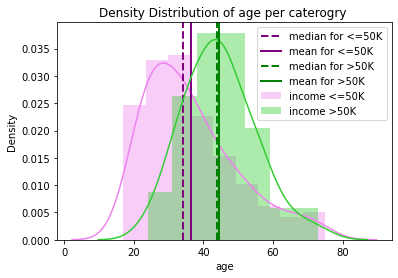

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# Plot density distribution of age including mean and median
sns.distplot(df_200_samples[df_200_samples['income'] ==0]['age'],kde=True, color='violet', label="income <=50K")
plt.axvline(x=df_200_samples[df_200_samples['income'] ==0]['age'].median(),color='purple',ls='--', lw=2, label='median for <=50K')
plt.axvline(x=df_200_samples[df_200_samples['income'] ==0]['age'].mean(),color='purple',ls='-', lw=2, label='mean for <=50K')

sns.distplot(df_200_samples[df_200_samples['income'] ==1]['age'],kde=True, color='limegreen', label="income >50K")
plt.axvline(x=df_200_samples[df_200_samples['income'] ==1]['age'].median(),color='green',ls='--', lw=2,label='median for >50K')
plt.axvline(x=df_200_samples[df_200_samples['income'] ==1]['age'].mean(),color='green',ls='-', lw=2,label='mean for >50K')

plt.title('Density Distribution of age per caterogry ')
plt.legend()
plt.show()

### Section 5

In [50]:
df_200_samples['rank'] = df_200_samples['age'].rank()
ranks_of_X=df_200_samples[df_200_samples['income'] ==1]['rank'].tolist()
s1=sum(ranks_of_X)

def permutation_test(n,m,s1,num_of_permutations):
    ranks=df_200_samples['rank'].values.tolist()
    permutations=[]
    counter=0
    iterations=num_of_permutations
    while iterations>0:
        control_ranks=random.sample(ranks, n1)
        if control_ranks  in permutations:
            continue
        else:
            permutations.append(control_ranks)
            iterations-=1
            new_s1=sum(control_ranks)
            if new_s1>=s1:
                counter+=1
    p_val=counter/num_of_permutations
    return p_val
    
p_value=permutation_test(n1,n2,s1,10000) 
print("P value is {0:.10f} ".format(p_value))
if p_value<0.05:
      print("We reject the null hypothesis.")
else:
    print("The null hypothesis cant be rejected.")

P value is 0.0000000000 
We reject the null hypothesis.


As seen, we rejected the null hypothesis on both tests, therefore, the distribution of age among people who earn more(>50K) is higher than the age of people who earn less (<=50K).

*We can use normal approximation because number of samples is greater than 30 for each category of income.


In [51]:
def vilcoxon_test_norm_approx(n,m,s1):
    expected_val=n*(1+n+m)/2
    se=np.sqrt(n*m*(n+m+1)/12)
    T=(s1-expected_val)/se
    return T
    
T=vilcoxon_test_norm_approx(n1,n2,s1) 
print("T is {0:.10f} ".format(T))
if T>= norm.ppf(0.05):
      print("We reject the null hypothesis.")
else:
    print("The null hypothesis cant be rejected.")

T is 4.4639617640 
We reject the null hypothesis.


### Section 6

Let's remind the relevant plot from previous exercise (2):

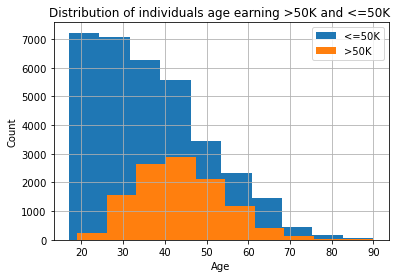

mean age of people who earn >50 is 44.00606709493219
mean age of people who earn <=50 is 36.749426706650205


In [63]:
df_full.groupby('income')['age'].hist()
plt.legend(np.array(["<=50K", ">50K"]))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Distribution of individuals age earning >50K and <=50K ")
plt.show()

print("mean age of people who earn >50 is {}".format(df_full[df_full["income"] ==1]["age"].mean()))
print("mean age of people who earn <=50 is {}".format(df_full[df_full["income"] ==0]["age"].mean()))

The results on Q3-Q5 were that there is a higher distribution of age among people who earn more(>50K) than the age of people who earn less (<=50K).

In the graph, we can see the same result:

We can see that the mean and median age of the people who earn more(>50K) is higher than the people who earn less (<=50K).

In addition, we can see that the whole distribution of the people who earn more(>50K) is centered (and located in general) on right (=higher) to the distribution of the people who earn less (<=50K).

In conclusion, we got results that matches the distribution of the age varibale in each category. 